# Problem - Statement

## About Yulu

Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.

Yulu zones are located at all the appropriate locations (including metro stations, bus stands, office spaces, residential areas, corporate offices, etc) to make those first and last miles smooth, affordable, and convenient!

Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.

## How you can help here?

The company wants to know:

1. Which variables are significant in predicting the demand for shared electric cycles in the Indian market?
2. How well those variables describe the electric cycle demands?

# Module Imports and Dataset

## Modules

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy import stats

## Datasets

In [ ]:
df = pd.read_csv('yulu.csv')
df.info()

**`Columns Description`**

| Column     | Description                                                                           |
|------------|---------------------------------------------------------------------------------------|
| `datetime` | datetime                                                                              |
| **`season`**   | **season (1: spring, 2: summer, 3: fall, 4: winter)**                                 |
| `holiday`  | whether day is a holiday or not (extracted from [holiday schedule](http://dchr.dc.gov/page/holiday-schedule)) |
| `workingday`| if day is neither weekend nor holiday is 1, otherwise is 0.                           |
| `weather`  | 1: Clear, Few clouds, partly cloudy, partly cloudy<br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog |
| `temp`     | temperature in Celsius                                                                |
| `atemp`    | feeling temperature in Celsius                                                        |
| `humidity` | humidity                                                                              |
| `windspeed`| wind speed                                                                            |
| `casual`   | count of casual users                                                                 |
| `registered`| count of registered users                                                            |
| `count`    | count of total rental bikes including both casual and registered                    |


# Data Cleaning and Preprocessing

## Basic Checks

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.isna().sum()

In [ ]:
df.duplicated().sum()

- No missing values are there.
- No duplicates are there.

In [ ]:
df.nunique()

- season, holiday, workingday and weather are the features that have 4, 2, 2 and 4 distinct values.
- So, these columns are categorical columns (and hence these features can be converted to categorical dtype).
- temp, atemp, humidity, windspeed, casual, registered, count are continous numerical features.

In [ ]:
categorical_features = ['season', 'holiday', 'workingday', 'weather']
numerical_features = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

In [ ]:
for feature in categorical_features:
    df[feature] = pd.Categorical(df[feature])

## Extracting time components
- *Converting datetime to pandas datetime format and Extracting time components*

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
first_date, last_date = np.min(df['datetime']), np.max(df['datetime'])
first_date, last_date

- Date is available for almost 2 full years (2011, 2012)

In [ ]:
df['year'] = pd.Categorical(df['datetime'].dt.year)
df['month'] = pd.Categorical(df['datetime'].dt.month)
df['week'] = pd.Categorical(df['datetime'].dt.isocalendar()['week'])
df['week_day'] = pd.Categorical(df['datetime'].dt.weekday)
df['hour'] = pd.Categorical(df['datetime'].dt.hour)

In [ ]:
def categorize_hour(hour: int) -> str:
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 16:
        return 'Afternoon'
    elif 16 <= hour < 20:
        return 'Evening'
    else:
        return 'Night'

In [ ]:
df['time_of_day'] = df['hour'].apply(categorize_hour)

In [ ]:
time_components = ['year', 'month', 'week', 'week_day', 'hour', 'time_of_day']

## Miscellaneous Checks

- Given Dataset is sanitized and useful features has been extracted.
- So, EDA can be started.

# EDA

## Basic Checks - shape, info() and describe() etc

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df[numerical_features].describe().T

In [ ]:
df[categorical_features + time_components].describe().T

### value_counts()

In [ ]:
for feature in categorical_features:
    print(df[feature].value_counts())
    print('--------------------------------')

In [ ]:
df['year'].value_counts()

In [ ]:
df['month'].value_counts()

In [ ]:
df['week_day'].value_counts()

In [ ]:
df['time_of_day'].value_counts()

## Box Plots and Histograms

### Utility functions

In [ ]:
# Function to find ouliers using IQR method
def findOutliersCount(series: pd.Series) -> int:
    q1 = np.quantile(series, 0.25)
    q3 = np.quantile(series, 0.75)

    iqr = q3 - q1

    outliers = series[~((q1 - 1.5*iqr <= series) & (series <= q3 + 1.5*iqr))]
    return len(outliers)

### of temp

In [ ]:
feature = "temp"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

In [ ]:
feature = "temp"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of temp (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of temp (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of temp (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of temp (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [ ]:
for season in df['season'].unique():
    temp = df.loc[df['season'] == season]["temp"]
    numOutliers = findOutliersCount(temp)
    print(f"Season {season} has {numOutliers} outliers of temp feature")

In [ ]:
for holiday in df['holiday'].unique():
    temp = df.loc[df['holiday'] == holiday]["temp"]
    numOutliers = findOutliersCount(temp)
    print(f"holiday {holiday} has {numOutliers} outliers of temp feature")

In [ ]:
for workingday in df['workingday'].unique():
    temp = df.loc[df['workingday'] == workingday]["temp"]
    numOutliers = findOutliersCount(temp)
    print(f"workingday {workingday} has {numOutliers} outliers of temp feature")

In [ ]:
for weather in df['weather'].unique():
    temp = df.loc[df['weather'] == weather]["temp"]
    numOutliers = findOutliersCount(temp)
    print(f"weather {weather} has {numOutliers} outliers of temp feature")

### of atemp

In [ ]:
feature = "atemp"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

In [ ]:
feature = "atemp"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of atemp (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of atemp (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of atemp (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of atemp (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [ ]:
for season in df['season'].unique():
    atemp = df.loc[df['season'] == season]["atemp"]
    numOutliers = findOutliersCount(atemp)
    print(f"Season {season} has {numOutliers} outliers of atemp feature")

In [ ]:
for holiday in df['holiday'].unique():
    atemp = df.loc[df['holiday'] == holiday]["atemp"]
    numOutliers = findOutliersCount(atemp)
    print(f"holiday {holiday} has {numOutliers} outliers of atemp feature")

In [ ]:
for workingday in df['workingday'].unique():
    atemp = df.loc[df['workingday'] == workingday]["atemp"]
    numOutliers = findOutliersCount(atemp)
    print(f"workingday {workingday} has {numOutliers} outliers of atemp feature")

In [ ]:
for weather in df['weather'].unique():
    atemp = df.loc[df['weather'] == weather]["atemp"]
    numOutliers = findOutliersCount(atemp)
    print(f"weather {weather} has {numOutliers} outliers of atemp feature")

### of windspeed

In [ ]:
feature = "windspeed"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

In [ ]:
feature = "windspeed"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of windspeed (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of windspeed (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of windspeed (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of windspeed (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [ ]:
for season in df['season'].unique():
    windspeed = df.loc[df['season'] == season]["windspeed"]
    numOutliers = findOutliersCount(windspeed)
    print(f"Season {season} has {numOutliers} outliers of windspeed feature")

In [ ]:
for holiday in df['holiday'].unique():
    windspeed = df.loc[df['holiday'] == holiday]["windspeed"]
    numOutliers = findOutliersCount(windspeed)
    print(f"holiday {holiday} has {numOutliers} outliers of windspeed feature")

In [ ]:
for workingday in df['workingday'].unique():
    windspeed = df.loc[df['workingday'] == workingday]["windspeed"]
    numOutliers = findOutliersCount(windspeed)
    print(f"workingday {workingday} has {numOutliers} outliers of windspeed feature")

In [ ]:
for weather in df['weather'].unique():
    windspeed = df.loc[df['weather'] == weather]["windspeed"]
    numOutliers = findOutliersCount(windspeed)
    print(f"weather {weather} has {numOutliers} outliers of windspeed feature")

### of humidity

In [ ]:
feature = "humidity"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

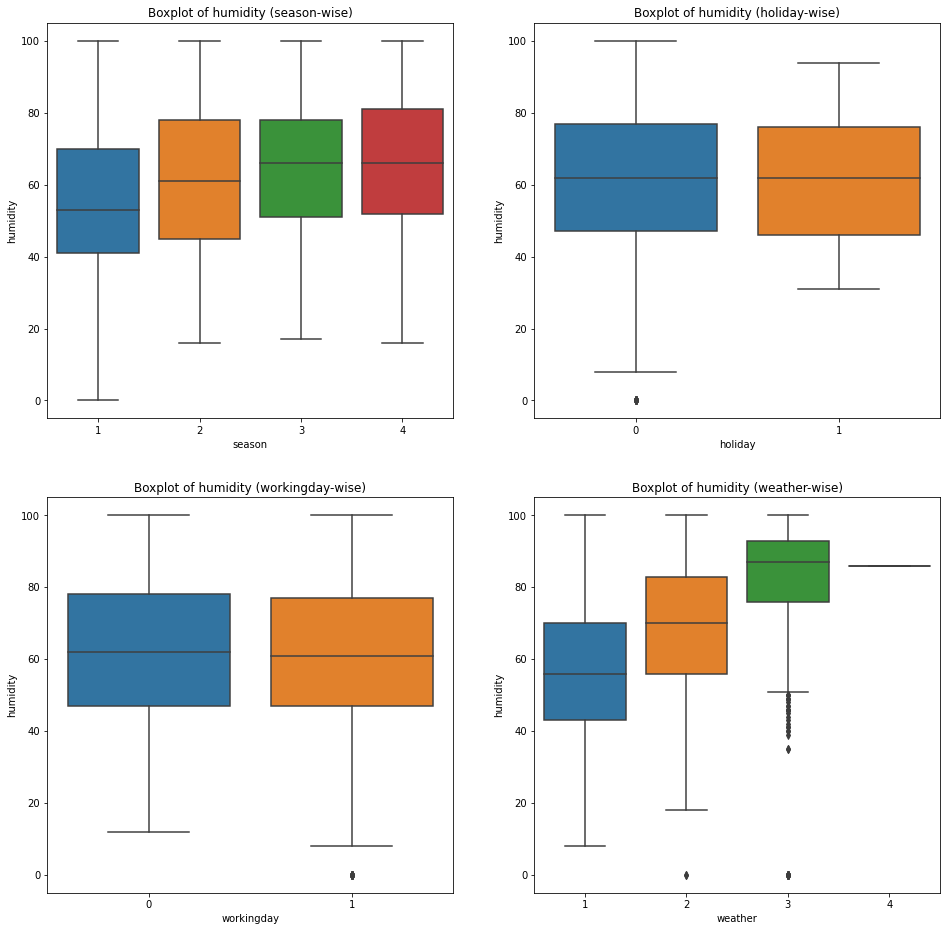

In [80]:
feature = "humidity"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of humidity (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of humidity (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of humidity (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of humidity (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [79]:
for season in df['season'].unique():
    humidity = df.loc[df['season'] == season]["humidity"]
    numOutliers = findOutliersCount(humidity)
    print(f"Season {season} has {numOutliers} outliers of humidity feature")

Season 1 has 0 outliers of humidity feature
Season 2 has 0 outliers of humidity feature
Season 3 has 0 outliers of humidity feature
Season 4 has 0 outliers of humidity feature


In [81]:
for holiday in df['holiday'].unique():
    humidity = df.loc[df['holiday'] == holiday]["humidity"]
    numOutliers = findOutliersCount(humidity)
    print(f"holiday {holiday} has {numOutliers} outliers of humidity feature")

holiday 0 has 22 outliers of humidity feature
holiday 1 has 0 outliers of humidity feature


In [83]:
for workingday in df['workingday'].unique():
    humidity = df.loc[df['workingday'] == workingday]["humidity"]
    numOutliers = findOutliersCount(humidity)
    print(f"workingday {workingday} has {numOutliers} outliers of humidity feature")

workingday 0 has 0 outliers of humidity feature
workingday 1 has 22 outliers of humidity feature


In [84]:
for weather in df['weather'].unique():
    humidity = df.loc[df['weather'] == weather]["humidity"]
    numOutliers = findOutliersCount(humidity)
    print(f"weather {weather} has {numOutliers} outliers of humidity feature")

weather 1 has 0 outliers of humidity feature
weather 2 has 2 outliers of humidity feature
weather 3 has 44 outliers of humidity feature
weather 4 has 0 outliers of humidity feature


### of Count

In [ ]:
feature = "count"
sns.histplot(x = feature, data = df)
plt.title(f"Histogram of {feature} recorded")

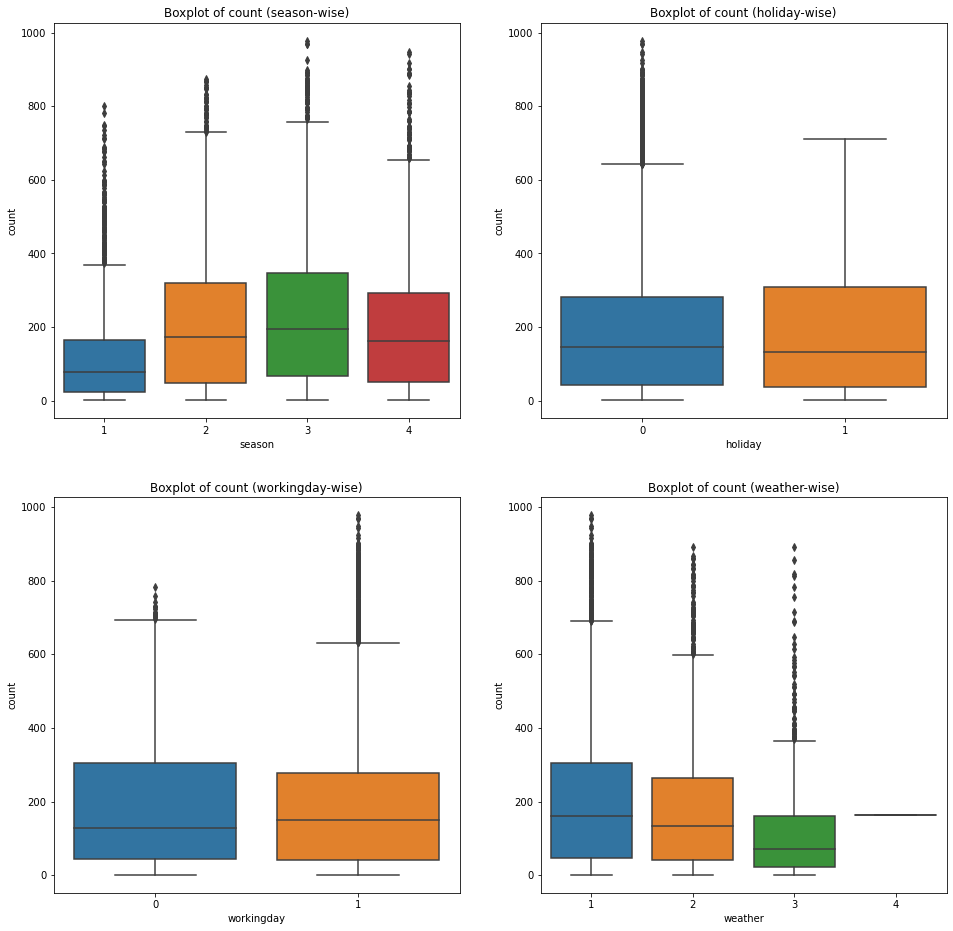

In [86]:
feature = "count"
fig, axs = plt.subplots(2, 2, figsize = (16, 16))

# boxplot of count (season-wise)
plt1 = sns.boxplot(data=df, x = "season", y = feature, ax = axs[0][0])
plt1.set_title(f"Boxplot of {feature} (season-wise)")

# boxplot of count (holiday-wise)
plt2 = sns.boxplot(data=df, x = "holiday", y = feature, ax = axs[0][1])
plt2.set_title(f"Boxplot of {feature} (holiday-wise)")

# boxplot of count (workingday-wise)
plt3 = sns.boxplot(data=df, x = "workingday", y = feature, ax = axs[1][0])
plt3.set_title(f"Boxplot of {feature} (workingday-wise)")

# boxplot of count (weather-wise)
plt4 = sns.boxplot(data=df, x = "weather", y = feature, ax = axs[1][1])
plt4.set_title(f"Boxplot of {feature} (weather-wise)")


plt.show()

#### Number of Outliers (using IQR method)

In [85]:
for season in df['season'].unique():
    count = df.loc[df['season'] == season]["count"]
    numOutliers = findOutliersCount(count)
    print(f"Season {season} has {numOutliers} outliers of count feature")

Season 1 has 139 outliers of count feature
Season 2 has 42 outliers of count feature
Season 3 has 61 outliers of count feature
Season 4 has 64 outliers of count feature


In [87]:
for holiday in df['holiday'].unique():
    count = df.loc[df['holiday'] == holiday]["count"]
    numOutliers = findOutliersCount(count)
    print(f"holiday {holiday} has {numOutliers} outliers of count feature")

holiday 0 has 311 outliers of count feature
holiday 1 has 0 outliers of count feature


In [88]:
for workingday in df['workingday'].unique():
    count = df.loc[df['workingday'] == workingday]["count"]
    numOutliers = findOutliersCount(count)
    print(f"workingday {workingday} has {numOutliers} outliers of count feature")

workingday 0 has 16 outliers of count feature
workingday 1 has 278 outliers of count feature


In [90]:
for weather in df['weather'].unique():
    count = df.loc[df['weather'] == weather]["count"]
    numOutliers = findOutliersCount(count)
    print(f"weather {weather} has {numOutliers} outliers of count feature")

weather 1 has 160 outliers of count feature
weather 2 has 82 outliers of count feature
weather 3 has 56 outliers of count feature
weather 4 has 0 outliers of count feature


## Group By Analysis

In [ ]:
agg_dict = {
    'temp': 'mean',
    'atemp': 'mean',
    'humidity': 'mean',
    'windspeed': 'mean',

    'casual': 'sum',
    'registered': 'sum',
    'count': 'sum'
}

### Group by season

In [ ]:
grouping_feature = "season"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by holiday

In [ ]:
grouping_feature = "holiday"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by workingday

In [ ]:
grouping_feature = "workingday"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by weather

In [ ]:
grouping_feature = "weather"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by year

In [ ]:
grouping_feature = "year"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by month

In [ ]:
grouping_feature = "month"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by week_day

In [ ]:
grouping_feature = "week_day"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

### Group by time_of_day

In [ ]:
grouping_feature = "time_of_day"

temp_df = df.groupby(grouping_feature).agg(agg_dict).reset_index()
temp_df

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "temp")
plt.title(f"Average temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "atemp")
plt.title(f"Average feeling temperature vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "humidity")
plt.title(f"Average humidity vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "windspeed")
plt.title(f"Average windspeed vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "casual")
plt.title(f"Number of casual users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "registered")
plt.title(f"Number of registered users vs {grouping_feature}")
plt.show()

In [ ]:
sns.barplot(data = temp_df, x = grouping_feature, y = "count")
plt.title(f"Number of total users vs {grouping_feature}")
plt.show()

## Co-relation checks

In [ ]:
df.info()

In [ ]:
sns.pairplot(df[numerical_features])

## Hypothesis/Statistical Testing